*Привет!*


*Меня зовут Кирилл, я буду проводить ревью твоего проекта.*


*Предлагаю общаться на «ты» :)* 


*Моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе стать отличным специалистом. Ниже ты найдешь мои комментарии, оформленные вот так: **«Комментарий ревьюера 🛸:…»***


*Помни, что все мои комментарии являются рекомендациями, а не требованиями – только ты решаешь, как сделать этот проект лучше.*


<div class="alert alert-danger">
<b>Комментарий ревьюера ❌:</b> </div>
    
Так выделены самые важные замечания. Эти замечания очень важные! Их нужно обязательно отработать, перед тем как показывать работу другим специалистам по Data Science.
    


<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> </div>
    
Так выделены небольшие замечания. Я надеюсь, что их ты тоже учтешь - твой проект от этого станет только лучше.
    
<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> </div>
    
Так я выделяю правильные и верные действия, а так же все остальные комментарии.


# Матчинг товаров

### Цель 

На основе датасетов, обучающей и тренировочной выборки с помощью FAISS подготовить по 5 "похожих" товаров и оценить их по методу `accuracy@5`.

### Метрика

Необходимо максимизировать метрику `accuracy@5`, которая для каждого объекта вычисляется по формуле:

$$
accuracy@5 = 100 * \frac{\text{кол-во верно определённых похожих объектов из 5 возможных}} {5}
$$

### Данные

`base.csv` : база данных всех товаров.  Насчитывает 72 признака и 2918139 объектов. Индекс состоит из уникальных идентификаторов товаров.

`train.csv` : обучающая выборка, взятая из `base.csv`. Насчитывает 73 признака и 100000 объектов.  Индекс состоит из уникальных идентификаторов товаров.  Признаки включают столбец с размеченными экспертами идентификаторами похожих товаров из `base.csv`

 `validatation.csv` : база данных товаров, взятых из `base.csv`, для которых необходимо найти похожие.  Насчитывает 72 признака и 100000 объектов.  Индекс состоит из уникальных идентификаторов товаров.

`validation_answer.csv` : база данных, с разметкой похожих для товаров из `validatation.csv`. Насчитывает 100000 объектов. Индекс состоит из уникальных идентификаторов товаров.

## Загружаем данные

In [1]:
import pandas as pd
import numpy as np 
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Все необходимые импорты перенесены в начало. Есть описание проекта, лучше добавить еще описание данных</div>


<div class="alert alert-info">
<b>Комментарий студента:</b> Добавил выше.</div>


In [2]:
RANDOM_STATE = 12345
np.random.seed(RANDOM_STATE)

In [3]:
# Файл со всеми товарами
df_base = pd.read_csv('data/base.csv', index_col='Id')

# Тренировочный датасет
df_train = pd.read_csv('data/train.csv', index_col='Id')

# Выборка для валидации
df_validation = pd.read_csv('data/validation.csv', index_col='Id')
df_validation_answers = pd.read_csv('data/validation_answer.csv', index_col='Id')

## Анализируем данные

Признаки представляют из себя вектора чисел с плавающей точкой. Контекст и назначение признаков неизвестны:

In [4]:
df_base.head(5)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


Профайлер не работает, поэтому просто посмотрим гистограммы.

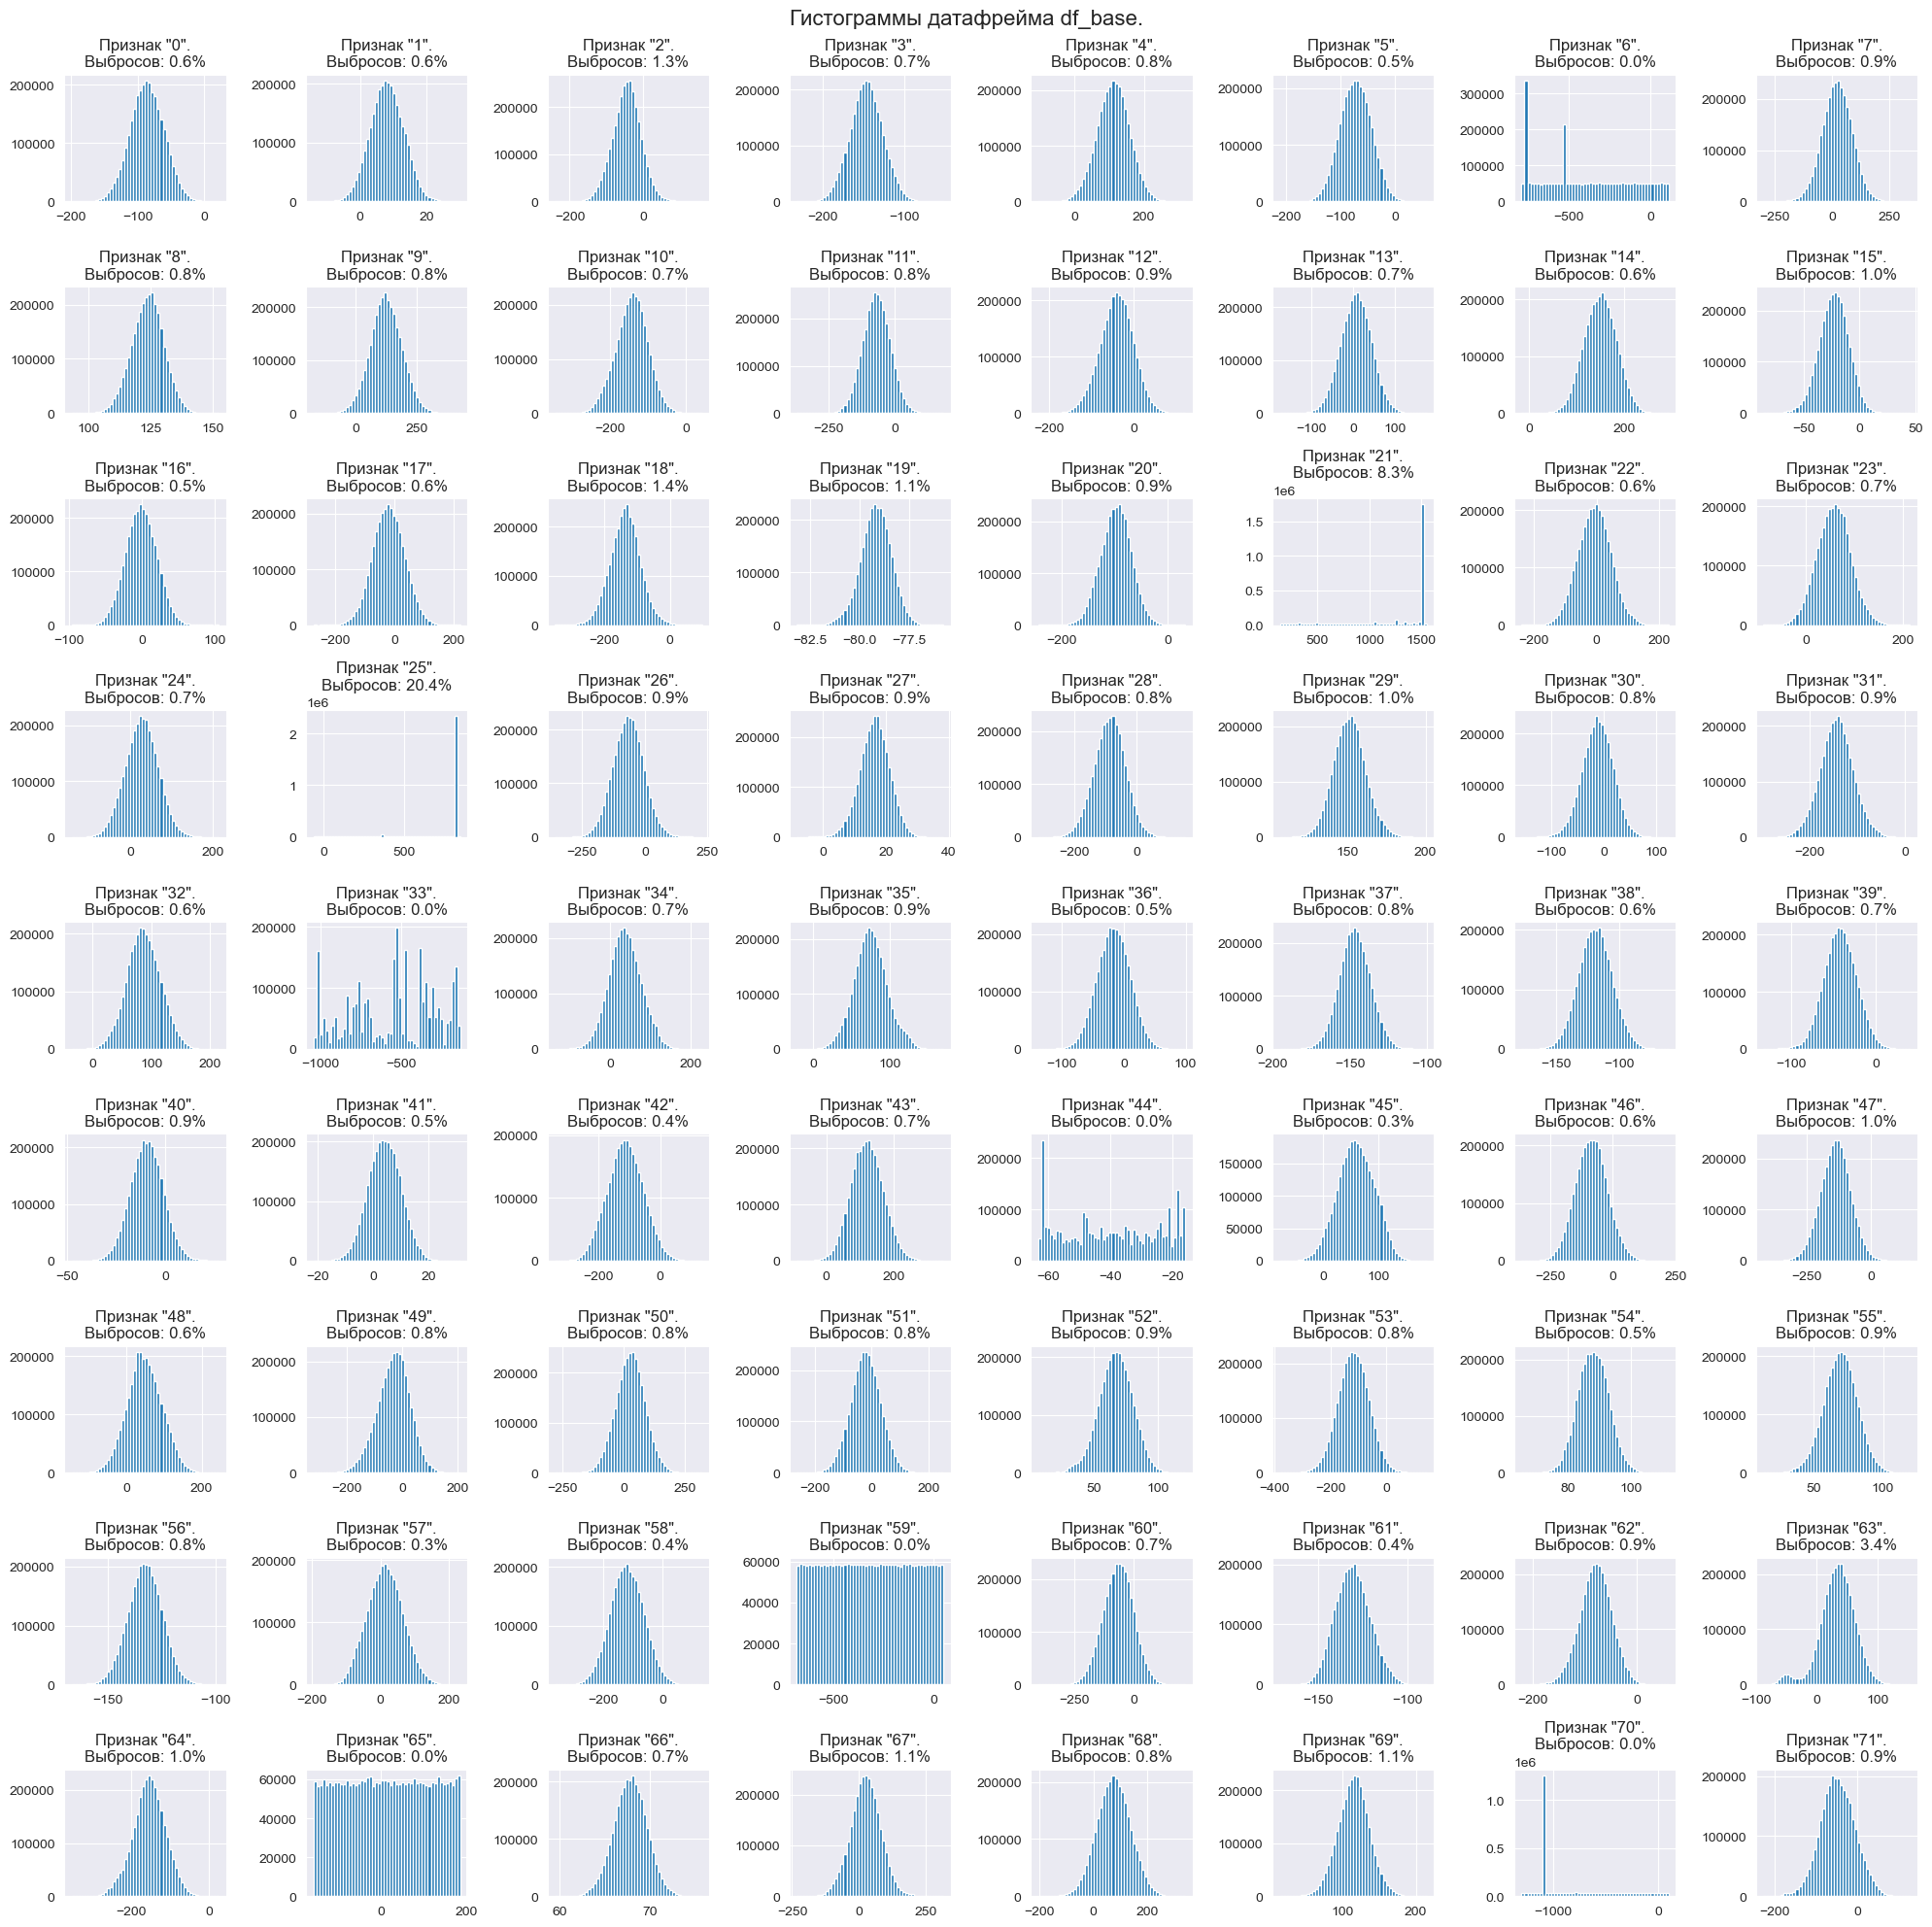

In [5]:
# Расчет выбросов по признаку

def get_outliers_ratio(col: pd.Series, iqr_coeff=1.5):
    
    # Вычислим интерквартильный размах.
    iqr_distance = col.quantile(.75) - col.quantile(.25)
    
    # Вычислим границы.
    whisker_upp = col.quantile(.75) + iqr_coeff * iqr_distance
    whisker_low = col.quantile(.25) - iqr_coeff * iqr_distance
    
    # Если усы границы экстремумы, приравняем их.
    if whisker_upp >= col.max():
        whisker_upp = col.max()
    if whisker_low <= col.min():
        whisker_low = col.min()
    else:
        pass
    
    # Вычислим процент выбросов.
    outliers_ratio = ( (col[col > whisker_upp].count() + col[col < whisker_low].count()) / len(col) )

    return outliers_ratio

axs = df_base.hist(figsize=[20, 20], bins=50)
for ax, col in zip(axs.flatten(), df_base.columns):
            outlier_perc = get_outliers_ratio(df_base[col], iqr_coeff=1.5)
            ax.set_title(f'Признак "{col}".\nВыбросов: ' + f'{outlier_perc:.1%}')
plt.suptitle('Гистограммы датафрейма df_base.', y=.99, fontsize=16)
plt.tight_layout()
plt.show();


<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> Покрупнее бы :) </div>
 


<div class="alert alert-info">
<b>Комментарий студента:</b> Сделал.</div>


Посмотрим корреляцию признаков. Видно, что где-то встречается обратная корреляция, но сильной прямой корреляции нет. Это значит, что нет необходимости убирать признаки только потому, что они сильно коррелируют друг с другом. Значит они характеризуют самые разные свойства товаров.

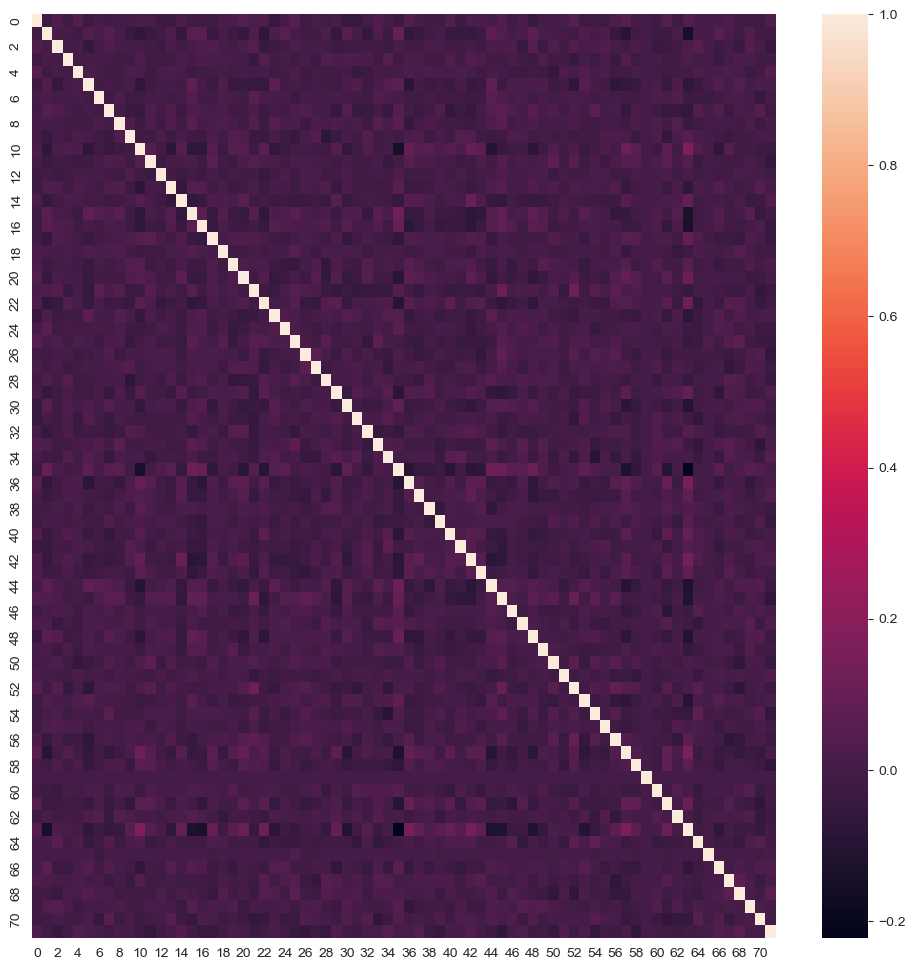

In [6]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df_base.corr(), ax=ax);

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> А какие выводы можно сделать? </div>
 


<div class="alert alert-info">
<b>Комментарий студента:</b> Добавил выше.</div>


Убедимся, что все таргеты в тренировочной и валидационной выборках есть в базовой выборке:

In [7]:
df_validation_answers.merge(df_base, how='inner', left_on='Expected', right_index=True).shape[0] == df_validation_answers.shape[0]

True

In [8]:
df_train[['Target']].merge(df_base, how='inner', left_on='Target', right_index=True).shape[0] == df_train.shape[0]

True

## Делаем прогноз

Функция для оценки результатов:

In [9]:
def accuracy_5(targets, predictions):
    success = 0
    for target, el in zip(targets.values.tolist(), predictions.tolist()):
        success += int(target in [base_index[r] for r in el])
    return 100 * success / len(predictions)

Заранее готовим словарь для конверсии индекса в идентификатор товара:

In [10]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

Готовим тренировочную выборку:

In [11]:
y_train = df_train["Target"]
X_train = df_train.drop("Target", axis=1)

Готовим валидационную выборку:

In [12]:
y_validation = df_validation_answers['Expected']
X_validation = df_validation

Стандартизуем с помощью `RobustScaler`:

In [13]:
transformer = RobustScaler().fit(df_base.values)
df_base_transformed = pd.DataFrame(index=df_base.index, data=transformer.transform(df_base.values))
X_train_transformed = pd.DataFrame(index=X_train.index, data=transformer.transform(X_train.values))
X_validation_transformed = pd.DataFrame(index=X_validation.index, data=transformer.transform(X_validation.values))

Методом проб и ошибок я выяснил, что часть колонок снижают аккуратность предсказаний (аргументация в следуюшем разделе). Причем не только те, у которых не нормальное распределение, но и с нормальным распределнием. Например признак `2`. Формируем список колонок, которые будем использовать для обучения:

In [14]:
excluded_columns = [2,21,25,33,40,42,52,54,59,60,61,65,66]
columns = [i for i in range(0,72) if i not in excluded_columns]


<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> А если бы удалять нужно было 1000 колонок, то так же бы удалял? Хотя бы через цикл for это сделать лучше :) </div>
 


<div class="alert alert-info">
<b>Комментарий студента:</b> Осталось с операции перебора удаления колонок. Сделал циклом. </div>
 


Строим модель и обучаем на тренировочных данных:

In [15]:
%%time

dims = df_base_transformed[columns].shape[1]
n_cells = 1
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells, faiss.METRIC_L2)
idx_l2.train(np.ascontiguousarray(df_base_transformed[columns]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_transformed[columns]).astype('float32'))
r, idx = idx_l2.search(np.ascontiguousarray(X_train_transformed[columns]).astype('float32'), 5)
print("Аккуратность предсказаний на тренировочной выборке с n_cells=1:", accuracy_5(y_train, idx), "%")

Аккуратность предсказаний на тренировочной выборке с n_cells=1: 71.644 %
CPU times: user 1h 25min 28s, sys: 24.8 s, total: 1h 25min 52s
Wall time: 9min 6s


In [16]:
%%time

dims = df_base_transformed[columns].shape[1]
n_cells = 10
quantizer = faiss.IndexFlatL2(dims)
idx_l2_cells_10 = faiss.IndexIVFFlat(quantizer, dims, n_cells, faiss.METRIC_L2)
idx_l2_cells_10.train(np.ascontiguousarray(df_base_transformed[columns]).astype('float32'))
idx_l2_cells_10.add(np.ascontiguousarray(df_base_transformed[columns]).astype('float32'))
r, idx = idx_l2_cells_10.search(np.ascontiguousarray(X_train_transformed[columns]).astype('float32'), 5)
print("Аккуратность предсказаний на тренировочной выборке с n_cells=10:", accuracy_5(y_train, idx), "%")

Аккуратность предсказаний на тренировочной выборке с n_cells=10: 63.526 %
CPU times: user 9min 51s, sys: 6.37 s, total: 9min 57s
Wall time: 1min 5s


In [17]:
%%time

dims = df_base_transformed[columns].shape[1]
n_cells = 100
quantizer = faiss.IndexFlatL2(dims)
idx_l2_cells_100 = faiss.IndexIVFFlat(quantizer, dims, n_cells, faiss.METRIC_L2)
idx_l2_cells_100.train(np.ascontiguousarray(df_base_transformed[columns]).astype('float32'))
idx_l2_cells_100.add(np.ascontiguousarray(df_base_transformed[columns]).astype('float32'))
r, idx = idx_l2_cells_100.search(np.ascontiguousarray(X_train_transformed[columns]).astype('float32'), 5)
print("Аккуратность предсказаний на тренировочной выборке с n_cells=100:", accuracy_5(y_train, idx), "%")

Аккуратность предсказаний на тренировочной выборке с n_cells=100: 62.966 %
CPU times: user 1min 11s, sys: 5.33 s, total: 1min 16s
Wall time: 11 s


<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> Почему n_cells=1? Есть более оптимальные параметры индекса</div>
 


<div class="alert alert-info">
<b>Комментарий студента:</b> Со значением больше 1 ищет быстрее, но качество сильно падает. </div>
 


Проверяем модель на валидационной выборке:

In [18]:
%%time

r, idx = idx_l2.search(np.ascontiguousarray(X_validation_transformed[columns]).astype('float32'), 5)
print("Аккуратность предсказаний на валидационной выборке:", accuracy_5(y_validation, idx), "%")

Аккуратность предсказаний на валидационной выборке: 71.384 %
CPU times: user 1h 26min 31s, sys: 23.2 s, total: 1h 26min 54s
Wall time: 9min


Сохраняем индекс для веб-сервиса:

In [19]:
faiss.write_index(idx_l2, './model.index')

# Выводы

Так как у нас анонимизированные признаки, да еще и закодированные, мы не знаем, какой признак важен, а какой нет.

Похожесть товаров в сервисах товарных рекомендаций делается довольно просто. Для этого не требуется 72 признака. Главный признак, который влияет на схожесть товаров: категория товара. Два товара из двух разных категорий не могут быть схожи. Поэтому должно быть точное совпадение категории.

Затем уже сверяются остальные признаки, такие как характеристики или цена. Но характеристики тоже зависят от категории. Ширина в разделе "Смартфоны" не то же самое, что ширина в разделе "Шкафы". При этом мы не знаем, как в нашем датасете закодирована ширина: она отмасштабирована по всему датасету или в рамках каждой категории (между минимумом и максимумом).

Нюансов и проблем много. Поэтому перебор гиперпараметров и вариантов моделей не является лучшим способом для разработки подходящей модели. Для начала нужно исключить "вредные" признаки. Те, которые никак не связаны с похожестью товаров. Я это сделал, просто по очереди удаляя колонки и проверяя, растет ли метрика или падает. Если падает, то колонка возвращается обратно.

Таким образом удалось найти 14 признаков, негативно влияющих на аккуратность предсказаний. Причем явных визуальных критериев для удаления нет. Например признак №1 не имеет нормального распределения, но его удаление ведет к сильному снижению точности. А признак 2 распределен нормально, но его наличие снижает точность.

В условиях ограничения по времени, как MVP это решение работоспособно. В дальнейшем можно уже оптимизировать гиперпараметры и пробовать другие виды моделей для улучшения качества. 


<div class="alert alert-success">
<h2>Заключение ревьювера: </h2> 


Михаил, у тебя получился очень крутой проект! 


⚠️✅ По оформлению работы: Все выполнено аккуратно и со знанием дела, но не хватает более подробного описания проекта и данных общего. Также старайся больше писать комментариев к коду и выводов после каждого этапа. Где нужны циклы - используй циклы, не удаляй каждую колонку отдельно, это неоптимально. 
    
⚠️✅ Предобработка данных: Хотелось бы, чтобы ты больше времени уделил именно анализу данных и обработке признаков. В целом то что сделано - сделано правильно, но есть еще пространство для исследований.
    
⚠️✅ Обучение модели: Посмотри лучше параметры faiss и какой параметр за что отвечает, поиграйся с различными индексами. Также в дальнейшем можно попробовать обучить ранжировщик (вам должны были рассказывать об этом) выдачи фаисса и попробовать поднять метрики.
        
**Было приятно с тобой поработать:)**
